Total data: 1804 days (2018-10-17 to 2025-12-19)
Trading starts: 2021-12-31 (index 807)

Processing 51 rebalance points (instead of 997 days)...

Rebalance 1/51 - Day 0/997 (0.0%)
Rebalance 2/51 - Day 20/997 (2.0%)
Rebalance 3/51 - Day 40/997 (4.0%)
Rebalance 4/51 - Day 60/997 (6.0%)
Rebalance 5/51 - Day 80/997 (8.0%)
Rebalance 6/51 - Day 100/997 (10.0%)
Rebalance 7/51 - Day 120/997 (12.0%)
Rebalance 8/51 - Day 140/997 (14.0%)
Rebalance 9/51 - Day 160/997 (16.0%)
Rebalance 10/51 - Day 180/997 (18.1%)
Rebalance 11/51 - Day 200/997 (20.1%)
Rebalance 12/51 - Day 220/997 (22.1%)
Rebalance 13/51 - Day 240/997 (24.1%)
Rebalance 14/51 - Day 260/997 (26.1%)
Rebalance 15/51 - Day 280/997 (28.1%)
Rebalance 16/51 - Day 300/997 (30.1%)
Rebalance 17/51 - Day 320/997 (32.1%)
Rebalance 18/51 - Day 340/997 (34.1%)
Rebalance 19/51 - Day 360/997 (36.1%)
Rebalance 20/51 - Day 380/997 (38.1%)
Rebalance 21/51 - Day 400/997 (40.1%)
Rebalance 22/51 - Day 420/997 (42.1%)
Rebalance 23/51 - Day 440/997 (44.1%)


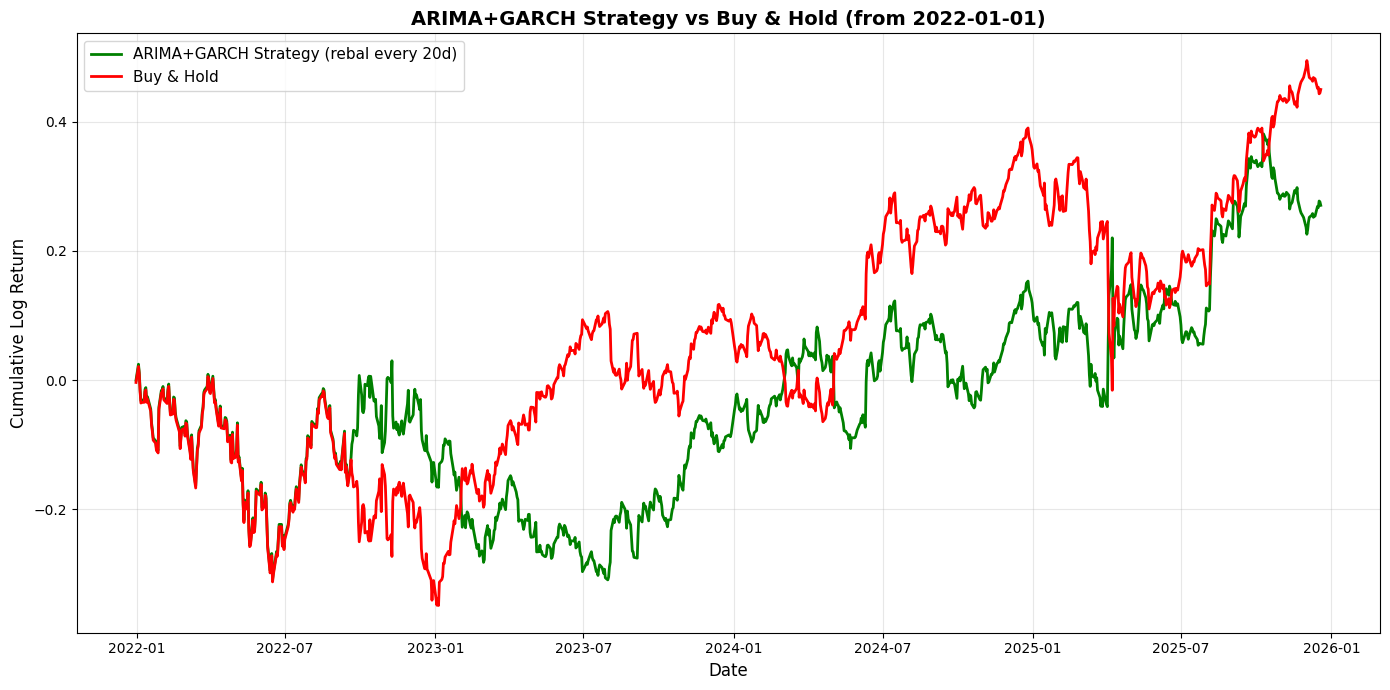

In [ ]:
import sqlite3
from pathlib import Path
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')

# Get project root (go up one level from models/ folder)
BASE_DIR = Path(os.getcwd()).parent

# Load config dynamically
import importlib.util
spec = importlib.util.spec_from_file_location("config", BASE_DIR / "config.py")
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

# Configuration from config.py
DB_PATH = BASE_DIR / "data" / "processed" / "data_processed.sqlite"
START_DATE = config.BACKTEST_START_DATE
WINDOW_LENGTH = config.WINDOW_LENGTH
P_MAX = 3  # Reduced from 5 to 3 for speed
Q_MAX = 3  # Reduced from 5 to 3 for speed
REBALANCE_DAYS = 20  # Only refit model every 20 days (monthly)

def load_data_from_sqlite():
    """Load stock data from SQLite."""
    with sqlite3.connect(DB_PATH) as conn:
        tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
        if tables.empty:
            raise RuntimeError(f"No tables found in {DB_PATH}")
        table_name = tables["name"].iloc[0]
        
        df = pd.read_sql(
            f'SELECT Date, Close FROM "{table_name}" ORDER BY Date', 
            conn, 
            parse_dates=["Date"]
        )
    
    df = df.set_index("Date")
    df['returns'] = np.log(df['Close']).diff()
    df = df.dropna(subset=['returns'])
    
    return df

# Load ALL data
df = load_data_from_sqlite()
returns = df['returns'].values
dates = df.index

print(f"Total data: {len(df)} days ({dates[0].date()} to {dates[-1].date()})")

# Find START_DATE index
start_idx = df.index.get_indexer([pd.to_datetime(START_DATE)], method='nearest')[0]
print(f"Trading starts: {dates[start_idx].date()} (index {start_idx})")

if start_idx < WINDOW_LENGTH:
    raise ValueError(f"Need {WINDOW_LENGTH} days before {START_DATE}. Only have {start_idx} days.")

# Calculate forecasts from START_DATE onwards (REBALANCE ONLY)
forecasts_length = len(returns) - start_idx
forecasts = np.zeros(forecasts_length)
directions = np.zeros(forecasts_length)

# Only refit model every REBALANCE_DAYS
rebalance_points = list(range(0, forecasts_length, REBALANCE_DAYS))
if rebalance_points[-1] != forecasts_length - 1:
    rebalance_points.append(forecasts_length - 1)

print(f"\nProcessing {len(rebalance_points)} rebalance points (instead of {forecasts_length} days)...\n")

current_forecast = 0
current_direction = 1

for idx, i in enumerate(rebalance_points):
    print(f"Rebalance {idx+1}/{len(rebalance_points)} - Day {i}/{forecasts_length} ({100*i/forecasts_length:.1f}%)")
    
    # Rolling window: WINDOW_LENGTH days ending at (start_idx + i)
    window_start = start_idx + i - WINDOW_LENGTH
    window_end = start_idx + i
    roll_returns = returns[window_start:window_end]
    
    # Find best ARIMA model
    final_aic = np.inf
    final_order = (1, 0, 1)
    
    for p in range(1, P_MAX + 1):
        for q in range(1, Q_MAX + 1):
            try:
                model = ARIMA(roll_returns, order=(p, 0, q)).fit(disp=0)
                current_aic = model.aic
                
                if current_aic < final_aic:
                    final_aic = current_aic
                    final_order = (p, 0, q)
            except:
                continue
    
    # Fit GARCH(1,1) model
    try:
        spec = arch_model(
            roll_returns,
            mean='ARX',
            lags=final_order[0],
            vol='GARCH',
            p=1,
            q=1,
            dist='skewt'
        )
        fit = spec.fit(disp='off', show_warning=False)
        
        fore = fit.forecast(horizon=1)
        current_forecast = fore.mean.iloc[-1, 0]
        current_direction = 1 if current_forecast > 0 else -1
        
    except:
        current_forecast = 0
        current_direction = 1
    
    # Fill in forecast for all days until next rebalance
    if idx < len(rebalance_points) - 1:
        next_i = rebalance_points[idx + 1]
        forecasts[i:next_i] = current_forecast
        directions[i:next_i] = current_direction
    else:
        forecasts[i:] = current_forecast
        directions[i:] = current_direction

print("\nForecasting complete!\n")

# Create series starting from START_DATE
forecast_dates = dates[start_idx:]
forecasts_series = pd.Series(forecasts, index=forecast_dates)
directions_series = pd.Series(directions, index=forecast_dates)

# Shift signals by 1 day
strategy_direction = directions_series.shift(1)
strategy_direction.iloc[0] = 0

# Calculate returns
market_returns = pd.Series(returns[start_idx:], index=forecast_dates)
strategy_returns = strategy_direction * market_returns

# Cumulative returns
strategy_curve = strategy_returns.cumsum()
market_curve = market_returns.cumsum()

# Performance metrics
total_strategy = (np.exp(strategy_curve.iloc[-1]) - 1) * 100
total_market = (np.exp(market_curve.iloc[-1]) - 1) * 100

n_trades = (strategy_direction.diff() != 0).sum()  # Position changes
n_long = (strategy_direction == 1).sum()
n_short = (strategy_direction == -1).sum()
n_wins = (strategy_returns > 0).sum()
win_rate = (n_wins / len(strategy_returns[strategy_returns != 0]) * 100) if len(strategy_returns[strategy_returns != 0]) > 0 else 0

sharpe_strategy = (strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)) if strategy_returns.std() > 0 else 0
sharpe_market = (market_returns.mean() / market_returns.std() * np.sqrt(252)) if market_returns.std() > 0 else 0

cum_strategy = (1 + strategy_returns).cumprod()
running_max = cum_strategy.expanding().max()
drawdown = (cum_strategy - running_max) / running_max
max_dd = drawdown.min() * 100

print("="*60)
print("PERFORMANCE RESULTS")
print("="*60)
print(f"Period: {forecast_dates[0].date()} to {forecast_dates[-1].date()}")
print(f"Rebalancing: Every {REBALANCE_DAYS} days")
print(f"\nStrategy Return: {total_strategy:>12.2f}%")
print(f"Buy & Hold Return: {total_market:>12.2f}%")
print(f"Excess Return: {total_strategy - total_market:>12.2f}%")
print(f"\nStrategy Sharpe: {sharpe_strategy:>12.2f}")
print(f"Buy & Hold Sharpe: {sharpe_market:>12.2f}")
print(f"\nMax Drawdown: {max_dd:>12.2f}%")
print(f"Win Rate: {win_rate:>12.2f}%")
print(f"\nTotal Trades: {n_trades:>12.0f}")
print(f"Long Days: {n_long:>12.0f}")
print(f"Short Days: {n_short:>12.0f}")
print("="*60)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(strategy_curve.index, strategy_curve.values, color='green', 
         label=f'ARIMA+GARCH Strategy (rebal every {REBALANCE_DAYS}d)', linewidth=2)
plt.plot(market_curve.index, market_curve.values, color='red', 
         label='Buy & Hold', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Log Return', fontsize=12)
plt.title(f'ARIMA+GARCH Strategy vs Buy & Hold (from {START_DATE})', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()